This notebook will analyze various datasets with regards to minority representation across various industries, with an additional focus on STEM fields. The primary goal is to find discrepancies in representative statistics between the raw data and those yielded from data mining algorithms.

The following historical data will be used to illustrate differences between the proportions of racially-classified "professionals" (college graduates) against the race-based percentage of the population in 2011 (the year chosen as this had the most complete employment records across all industries). The ratios of professionals is taken from the United States Equal Employment Opportunity Commission's statistics on employees across all industries in all 51 states/territories, while the race-based percentages of the population are calculated from United States Census records.

This is not meant to demonstrate data mining techniques, but rather to provide some historical background on race-based discrepancies in hiring.

In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm

cols = ['State', 'nac2Label', 'totProf/StInd',  
        'whiteProfessionalTotal', 'blackProfessionalTotal', 'hispanicOrLatinoProfessionalTotal', 
        'asianProfessionalTotal', 'americIndianProfessionalTotal', 'pacificIslanderProfessionalTotal']

df = pd.read_csv("inputs/CountByStateAndIndustryNAC-2.csv", usecols=cols, nrows=957)

df = df.loc[(df['nac2Label'] == 'Information') | (df['nac2Label'] == 'Professional, Scientific, and Technical Services')]

df = df.drop(columns=['nac2Label'])

df = df.groupby('State', sort=True).sum(numeric_only=True)

df = df.rename(columns={'totProf/StInd': 'Total Professionals', 'whiteProfessionalTotal': 'White Professionals',
                       'blackProfessionalTotal': 'Black Professionals', 'hispanicOrLatinoProfessionalTotal': 'Hispanic Professionals',
                       'asianProfessionalTotal': 'Asian Professionals', 'americIndianProfessionalTotal': 'American Indian Professionals',
                       'pacificIslanderProfessionalTotal': 'Pacific Islander Professionals'})

df

,Total Professionals,White Professionals,Black Professionals,Hispanic Professionals,Asian Professionals,American Indian Professionals,Pacific Islander Professionals
State,,,,,,,
Alabama,62826,52011,4182,3467,755,2167,38
Alaska,2827,2381,156,103,65,82,13
Arizona,22336,16609,787,2030,2417,151,76
Arkansas,5834,4658,436,94,561,21,6
California,277600,156349,8761,20929,84493,835,1531
Colorado,51776,43086,1501,2921,3335,210,105
Connecticut,21139,16107,979,810,3061,35,27
Delaware,2858,2132,285,76,321,6,6
District of Columbia,36907,26005,4790,1441,4011,79,67


In [13]:
true_prop_2011 = np.array([.628, .123, .169, .049, .007, .002]) # Adapted from non-CSV charts of 2011 population estimates

np.set_printoptions(precision=5, suppress=True)
state_profs = df.values[:,1:7].astype(float)
state_totals = df.values[:,0]

total_prof = state_totals.sum()

prop = np.zeros((6)).astype(float)

for i in range(state_profs.shape[1]):
    prop[i] = state_profs[:, i].sum() / total_prof

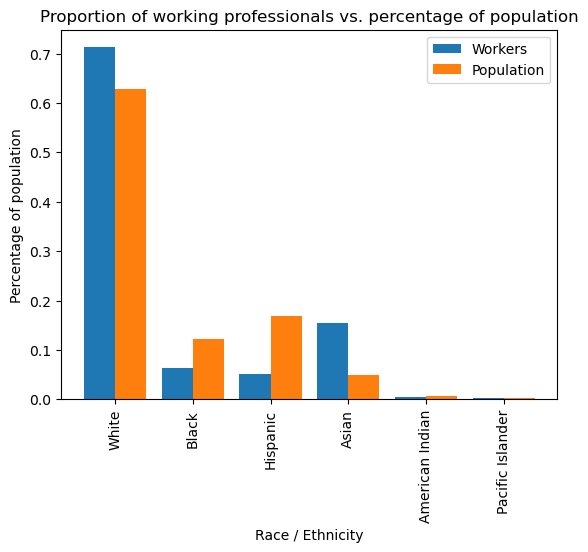

In [14]:
import matplotlib.pyplot as plt

X = ['White', 'Black', 'Hispanic', 'Asian', 'American Indian', 'Pacific Islander']

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, prop, 0.4, label = 'Workers')
plt.bar(X_axis + 0.2, true_prop_2011, 0.4, label = 'Population')

plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Race / Ethnicity")
plt.ylabel("Percentage of population")
plt.title("Proportion of working professionals vs. percentage of population")
plt.legend()

plt.show()

The disparities shown above, although limited in scope to what the EEOC was able to quantify, does seem to demonstrate that white graduates are oversampled across the totality of the data's STEM related fields, while black and Hispanic candidates are extremely undersampled. A key difference is in the additional oversampling of Asian college graduates in the workforce, one that we will revisit later on.

Next we will attempt to resolve a classification problem with regards to race with a simulated human resources dataset of employee records.

In [15]:
import seaborn as sns

df = pd.read_csv('inputs/HRDataset_v13.csv')
df.dropna(how='all', inplace=True)
df.RaceDesc.name = 'Racial Group'
display(df.RaceDesc.value_counts(), df.RaceDesc.value_counts(normalize=True) * 100)

White                               193
Black or African American            57
Asian                                34
Two or more races                    18
American Indian or Alaska Native      4
Hispanic                              4
Name: Racial Group, dtype: int64

White                               62.258065
Black or African American           18.387097
Asian                               10.967742
Two or more races                    5.806452
American Indian or Alaska Native     1.290323
Hispanic                             1.290323
Name: Racial Group, dtype: float64

Next we will isolate only the purely quantitative features of the dataset regarding each employee, including a race-based ground truth label. In addition, we will only examine "Active" employees, as the other statuses were too few and far between to make any real statistical impact through analysis.

In [16]:
df = df[df['EmploymentStatus'] == 'Active']
relevant_info = ['RaceDesc', 'PerfScoreID', 'EngagementSurvey','GenderID']
display(df[relevant_info])

,RaceDesc,PerfScoreID,EngagementSurvey,GenderID
0,Black or African American,3.0,2.04,0.0
1,Black or African American,3.0,5.00,1.0
2,White,3.0,3.90,1.0
4,White,3.0,5.00,0.0
7,White,3.0,5.00,0.0
...,...,...,...,...
298,White,3.0,3.84,1.0
299,White,3.0,5.00,0.0
300,Asian,3.0,5.00,0.0
308,White,3.0,5.00,1.0


For classification purposes, each of the recorded racial groups will be coded to an integer value.

In [17]:
df.replace('Black or African American', 0.0, inplace=True)
df.replace('White', 1.0, inplace=True)
df.replace('Asian', 2.0, inplace=True)
df.replace('Hispanic', 3.0, inplace=True)
df.replace('Two or more races', 4.0, inplace=True)
df.replace('American Indian or Alaska Native', 5.0, inplace=True)
display(df[relevant_info])

,RaceDesc,PerfScoreID,EngagementSurvey,GenderID
0,0.0,3.0,2.04,0.0
1,0.0,3.0,5.00,1.0
2,1.0,3.0,3.90,1.0
4,1.0,3.0,5.00,0.0
7,1.0,3.0,5.00,0.0
...,...,...,...,...
298,1.0,3.0,3.84,1.0
299,1.0,3.0,5.00,0.0
300,2.0,3.0,5.00,0.0
308,1.0,3.0,5.00,1.0


Next, we will separate the features from the number-coded ground truth labels, and then partition each in the same manner into training, validation, and test sets (in a 7-2-1 ratio).

In [18]:
features = df[relevant_info].values[:, 0:]
labels = df[relevant_info].values[:, -1].astype(int)
print('array of labels: shape ' + str(np.shape(labels)))
print('array of feature matrix: shape ' + str(np.shape(features)))

array of labels: shape (182,)
array of feature matrix: shape (182, 4)


In [19]:
val_features, rem = np.split(features, [int(0.2 * features.shape[0])])
test_features, train_features = np.split(rem, [int(0.125 * rem.shape[0])])

val_labels, rem = np.split(labels, [int(0.2 * labels.shape[0])])
test_labels, train_labels = np.split(rem, [int(0.125 * rem.shape[0])])

print(np.shape(train_features))
print(np.shape(val_features))
print(np.shape(test_features))

print(np.shape(train_labels))
print(np.shape(val_labels))
print(np.shape(test_labels))

(128, 4)
(36, 4)
(18, 4)
(128,)
(36,)
(18,)


We will now perform a KNN algorithm to the data, using the 2 nearest neighbors as a baseline to start.

In [20]:
def KNN(train_features, train_labels, test_features, k=2):
    preds = []
    for i in tqdm(range(test_features.shape[0])):
        dist = np.sum(np.square(val_features[i] - train_features), axis=1)
        near_ind = np.argpartition(dist, k)[:k]
        near_lab = list(train_labels[near_ind])
        pred = max(near_lab, key=near_lab.count)
        preds.append(pred)
    return np.array(preds)

val_preds = KNN(train_features, train_labels, val_features)
print(val_preds.shape)

100%|██████████| 36/36 [00:00<00:00, 14515.95it/s]

(36,)


In [21]:
def evaluation(true, pred):
    acc = np.sum(pred == true) / len(true)

    micro_TP = 0
    micro_FP = 0
    micro_FN = 0
    micro_TN = 0
    macro_F1 = []

    for c in range(6):
        c_label_pos = (true == c)
        c_label_neg = ~c_label_pos
        c_pred_pos = (pred == c)
        c_pred_neg = ~c_pred_pos

        TP = np.sum(c_label_pos * c_pred_pos)
        FP = np.sum(c_label_neg * c_pred_pos)
        FN = np.sum(c_label_pos * c_pred_neg)
        TN = np.sum(c_label_neg * c_pred_neg)

        if TP == 0:
            precision = 0
            recall = 0
            F1 = 0
        else:
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            F1 = 2 * precision * recall / (precision + recall)
        macro_F1.append(F1)

        micro_TP += TP
        micro_FP += FP
        micro_TN += TN
        micro_FN += FN

    macro_F1 = np.mean(macro_F1)
    micro_precision = micro_TP / (micro_TP + micro_FP)
    micro_recall = micro_TP / (micro_TP + micro_FN)
    micro_F1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)

    print('accuracy = %.6f' % acc)
    print('macro F1 = %.6f' % macro_F1)
    print('micro F1 = %.6f' % micro_F1)
    
evaluation(val_labels, val_preds)

accuracy = 0.944444
macro F1 = 0.314583
micro F1 = 0.944444
